加入室外数据，室外光照强度，室外温度，室外风速，室外湿度

--- 开始处理文件: 'Strawberry Greenhouse Environmental Control Dataset(version2).csv' ---
--> 正在加载和预处理数据...
--> 数据预处理完成。维度: (31704, 15)

--- 正在构建物理基准模型 ---
--> 物理模型预测步长设定为: 120 分钟
---> 物理基准模型训练完成。

--- 正在构建与训练混合深度学习模型 (PyTorch) ---
--> 未来特征索引检查: [3, 4, 5, 6, 7] (确认包含了天气列的索引)
--- 正在构建数据集: 输入过去 120 分钟，预测未来 120 分钟 ---
--> 使用设备: cuda
--> 正在训练 混合模型(绝对值)...
--> 正在训练 混合模型(一阶差分)...

--- 性能对比 ---
[基准: 物理微分方程模型] MAE: 4.1693, RMSE: 5.6613, R2: 0.6389
[本文: 混合模型(绝对值)] MAE: 2.9040, RMSE: 3.9435, R2: 0.8248
[本文: 混合模型(一阶差分)] MAE: 2.8041, RMSE: 3.9057, R2: 0.8281


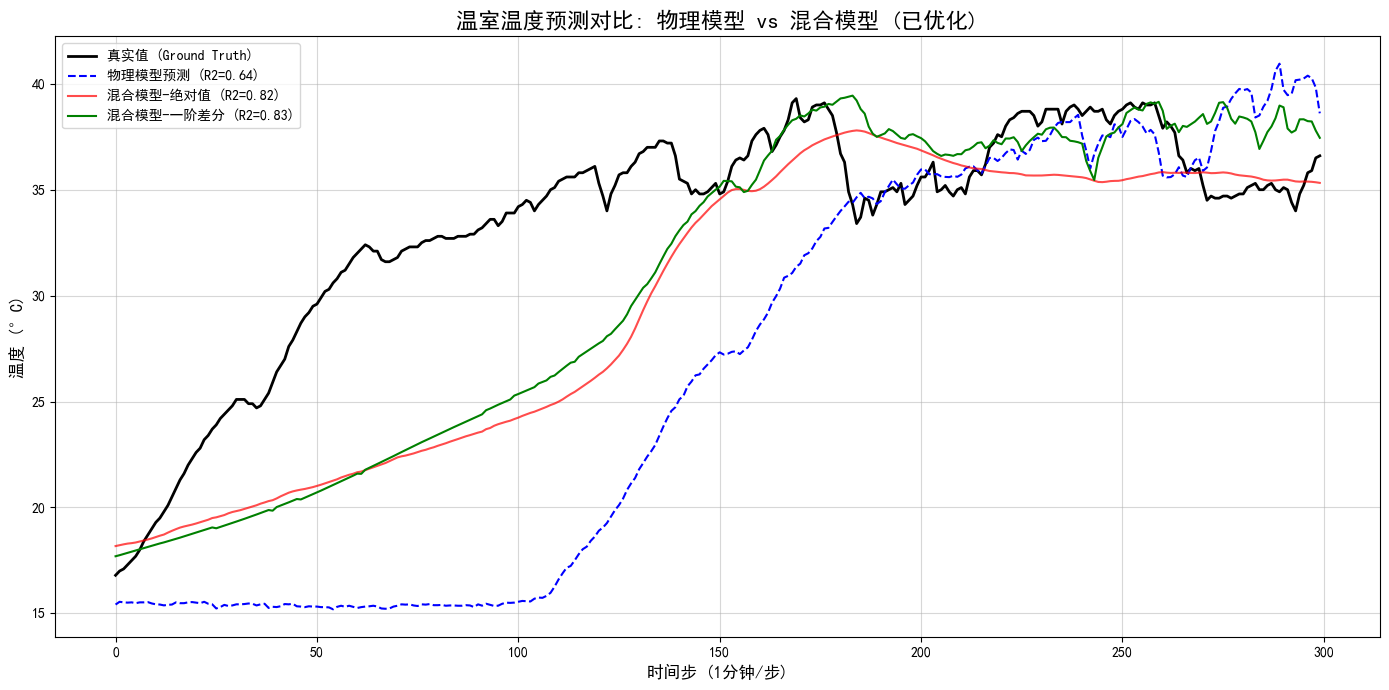


--- 结论分析 ---
1. 物理模型基于简化的线性假设，其 R2 分数为 0.6389。
2. 混合模型(绝对值方法) R2: 0.8248, MAE: 2.9040
3. 混合模型(一阶差分方法) R2: 0.8281, MAE: 2.8041


In [1]:
import pandas as pd
import sys
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import os

# === 辅助函数与类定义 (PyTorch) ===
# 创建时间序列数据
def create_sequences(data, seq_length, forecast_horizon, future_indices, target_idx):
    xs_past, xs_future, ys, y_bases = [], [], [], []
    # 确保不越界：数据总长度 - (输入序列长度 + 预测距离)
    for i in range(len(data) - seq_length - forecast_horizon + 1):
        # 输入：从 i 开始，取 seq_length 个点
        x_p = data[i:(i + seq_length)]
        # 未来控制序列：从 seq_length 结束开始，取 forecast_horizon 个点
        x_f = data[i + seq_length : i + seq_length + forecast_horizon, future_indices]
        # 任务二：输出整个预测序列 [t+1, ..., t+horizon]
        y = data[i + seq_length : i + seq_length + forecast_horizon, target_idx]
        # 基准值：输入序列的最后一个目标值，用于计算差分
        y_base = data[i + seq_length - 1, target_idx]
        xs_past.append(x_p)
        xs_future.append(x_f)
        ys.append(y)
        y_bases.append(y_base)
    return np.array(xs_past), np.array(xs_future), np.array(ys), np.array(y_bases)

# 2. 对比混合模型 (Complex Past + Simple GRU Future)
class SimpleFutureModel(nn.Module):
    def __init__(self, input_dim, future_dim, forecast_horizon, hidden_dim=32):
        super(SimpleFutureModel, self).__init__()
        # 历史数据处理分支 (CNN + BiGRU + Attention)
        self.past_conv1 = nn.Conv1d(in_channels=input_dim, out_channels=64, kernel_size=3, padding=1)
        self.past_bigru = nn.GRU(input_size=64, hidden_size=hidden_dim, num_layers=2, batch_first=True, bidirectional=True)
        self.past_attention = nn.Linear(hidden_dim * 2, 1)
       
        # 未来控制序列处理分支 (仅使用单向 GRU)
        self.future_gru = nn.GRU(input_size=future_dim, hidden_size=hidden_dim, num_layers=1, batch_first=True)
       
        # 融合层：历史特征 (hidden_dim * 2) + 未来特征 (hidden_dim)
        self.fc = nn.Linear(hidden_dim * 2 + hidden_dim, forecast_horizon)
    
    def forward(self, x_past, x_future):
        # 处理历史序列 (Complex)
        x_p = x_past.permute(0, 2, 1)
        x_p = torch.relu(self.past_conv1(x_p))
        x_p = x_p.permute(0, 2, 1)
        gru_out_p, _ = self.past_bigru(x_p)
        weights_p = torch.softmax(self.past_attention(gru_out_p), dim=1)
        attended_p = torch.sum(weights_p * gru_out_p, dim=1)
       
        # 处理未来控制序列 (Simple GRU)
        _, h_n = self.future_gru(x_future)
        future_features = h_n[-1]  # 取最后一个时间步
       
        # 特征融合
        combined = torch.cat([attended_p, future_features], dim=1)
        output = self.fc(combined)
        return output

# 评估指标计算
def calculate_metrics(y_true, y_pred, name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"[{name}] MAE: {mae:.4f}, RMSE: {rmse:.4f}, R2: {r2:.4f}")
    return mae, rmse, r2

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# --- 步骤 0: 初始设置 ---
filename = 'Strawberry Greenhouse Environmental Control Dataset(version2).csv'
print(f"--- 开始处理文件: '{filename}' ---")

try:
    # --- 步骤 1-3: 数据加载, 清洗, 重采样, 填充 ---
    print("--> 正在加载和预处理数据...")
    df = pd.read_csv(filename, encoding='latin1', sep=';', decimal=',', parse_dates=['Timestamp'], dayfirst=True, index_col='Timestamp')
    # 修复：在转换为数值之前处理开关量列，防止被 to_numeric 转为 NaN 而丢弃
    cols_to_binary = [' "Heater"', ' "Ventilation"', ' "Lighting"', ' "Pump 1"', ' "Valve 1"']
    for col in cols_to_binary:
        if col in df.columns:
            df[col] = df[col].apply(lambda x: 1 if str(x).lower() in ['on', 'yes', '1'] else 0)
    for col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    df.dropna(axis=1, how='all', inplace=True)
    df_resampled = df.resample('1min').mean().ffill().bfill()
    print(f"--> 数据预处理完成。维度: {df_resampled.shape}")
except Exception as e:
    print(f"处理数据时发生错误: {e}")
    sys.exit(1)

# --- 步骤 4: 物理基准模型构建 ---
print(f"\n--- 正在构建物理基准模型 ---")
# !!! 关键修改：将预测步长定义提前，确保物理模型和混合模型一致 !!!
# 1小时 = 60分钟 = 60 个 1分钟点
forecast_horizon = 120
print(f"--> 物理模型预测步长设定为: {forecast_horizon} 分钟")

physics_features = [' "Temperature, °C"', ' "Humidity, %"', ' "CO?, ppm"', ' "Heater"', ' "Ventilation"', ' "Lighting"', 'Outdoor_Temp', 'Outdoor_Hum', 'Outdoor_Wind', 'Outdoor_Solar']
target_col = ' "Temperature, °C"'
available_physics_features = [col for col in physics_features if col in df_resampled.columns]

# 准备数据
data = df_resampled[available_physics_features].dropna()
if len(data) < forecast_horizon + 1: sys.exit("错误: 物理模型数据不足。")

# !!! 修正数据切片逻辑 !!!
# 输入 X: 从 0 到 总长度 - horizon
# 输出 y: 从 horizon 到 结尾
# 这样建立了 X_t -> y_{t+60} 的关系
X_physics = data.iloc[:-forecast_horizon].copy()
y_physics = data[target_col].iloc[forecast_horizon:].values

control_features = [col for col in [' "Heater"', ' "Ventilation"', ' "Lighting"'] if col in available_physics_features and col != target_col]

# 使用所有可用的物理特征（包含室外天气等）
feature_columns = available_physics_features

# --- 物理模型增强：加入未来控制量的均值 ---
# 计算未来 forecast_horizon 时间段内的控制变量均值
X_physics_augmented = X_physics.copy()
for col in control_features:
    # rolling(window).mean() 计算的是过去窗口的均值，shift(-window) 将其对齐到未来
    # 这样 X_physics_augmented[t] 就包含了 t 到 t+horizon 期间 heater 的平均开启率
    X_physics_augmented[f'Future_Mean_{col}'] = data[col].rolling(window=forecast_horizon).mean().shift(-forecast_horizon).iloc[:-forecast_horizon]

feature_columns = feature_columns + [f'Future_Mean_{col}' for col in control_features]
X_physics_features = X_physics_augmented[feature_columns].fillna(0).values

train_size = int(len(X_physics) * 0.8)
if train_size == 0: sys.exit("错误: 训练数据不足。")

X_train_phy, X_test_phy = X_physics_features[:train_size], X_physics_features[train_size:]
y_train_phy, y_test_phy = y_physics[:train_size], y_physics[train_size:]

physics_model = LinearRegression()
physics_model.fit(X_train_phy, y_train_phy)
y_pred_phy = physics_model.predict(X_test_phy)
print("---> 物理基准模型训练完成。")

# --- 步骤 5: 混合深度学习模型构建 (PyTorch) ---
print("\n--- 正在构建与训练混合深度学习模型 (PyTorch) ---")

df_hybrid = df_resampled.copy()

# 引入时间位置特征 (Time-of-Day Encoding)
hour_float = df_hybrid.index.hour + df_hybrid.index.minute / 60.0
df_hybrid['Hour_Sin'] = np.sin(2 * np.pi * hour_float / 24.0)
df_hybrid['Hour_Cos'] = np.cos(2 * np.pi * hour_float / 24.0)

input_features = [' "Temperature, °C"', ' "Humidity, %"', ' "CO?, ppm"', ' "Heater"', ' "Ventilation"', ' "Lighting"', 'Outdoor_Temp', 'Outdoor_Hum', 'Outdoor_Wind', 'Outdoor_Solar', 'Hour_Sin', 'Hour_Cos']
available_input_features = [f for f in input_features if f in df_hybrid.columns]
target_index = available_input_features.index(target_col)

# 获取控制变量的索引
control_indices = [available_input_features.index(col) for col in control_features]

# 将时间特征也视为“已知未来”的控制变量
time_indices = [available_input_features.index(col) for col in ['Hour_Sin', 'Hour_Cos'] if col in available_input_features]

# 1. 定义天气列
weather_cols = ['Outdoor_Temp', 'Outdoor_Hum', 'Outdoor_Wind', 'Outdoor_Solar']
weather_indices = [available_input_features.index(col) for col in weather_cols if col in available_input_features]

# 2. 加入未来索引
# 逻辑：未来预测 = f(未来控制 + 未来时间 + 未来天气预报)
future_indices = control_indices + time_indices + weather_indices
print(f"--> 未来特征索引检查: {future_indices} (确认包含了天气列的索引)")

scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(df_hybrid[available_input_features])

# --- 数据集划分 (训练、验证、测试) ---
# --- 参数设置区域 ---
# 假设数据间隔是 5分钟 (df_resampled 是 5min 一行)
# 1. 设置输入窗口：比如看过去 2小时的数据来预测
# 2小时 = 120分钟 = 120 个 1分钟点
sequence_length = 120
print(f"--- 正在构建数据集: 输入过去 {sequence_length} 分钟，预测未来 {forecast_horizon} 分钟 ---")

# 原始训练数据
train_data_full = scaled_features[:train_size]
# 原始测试数据
test_data = scaled_features[train_size:]

# 将原始训练数据进一步划分为训练集和验证集 (80/20)
val_split_index = int(len(train_data_full) * 0.8)
train_data = train_data_full[:val_split_index]
val_data = train_data_full[val_split_index:]

# 创建序列
X_train_past, X_train_future, y_train, y_train_bases = create_sequences(train_data, sequence_length, forecast_horizon, future_indices, target_index)
X_val_past, X_val_future, y_val, y_val_bases = create_sequences(val_data, sequence_length, forecast_horizon, future_indices, target_index)
X_test_past, X_test_future, y_test_scaled, y_test_bases = create_sequences(test_data, sequence_length, forecast_horizon, future_indices, target_index)

if len(X_train_past) == 0 or len(X_val_past) == 0 or len(X_test_past) == 0:
    sys.exit("错误: 创建序列后数据不足以划分训练/验证/测试集。")

# 转换为PyTorch张量
X_train_past_tensor = torch.FloatTensor(X_train_past)
X_train_future_tensor = torch.FloatTensor(X_train_future)
y_train_tensor = torch.FloatTensor(y_train)
y_train_bases_tensor = torch.FloatTensor(y_train_bases).unsqueeze(1)

X_val_past_tensor = torch.FloatTensor(X_val_past)
X_val_future_tensor = torch.FloatTensor(X_val_future)
y_val_tensor = torch.FloatTensor(y_val)
y_val_bases_tensor = torch.FloatTensor(y_val_bases).unsqueeze(1)

X_test_past_tensor = torch.FloatTensor(X_test_past)
X_test_future_tensor = torch.FloatTensor(X_test_future)
y_test_bases_tensor = torch.FloatTensor(y_test_bases).unsqueeze(1)

# 创建DataLoader
train_dataset = TensorDataset(X_train_past_tensor, X_train_future_tensor, y_train_tensor, y_train_bases_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

val_dataset = TensorDataset(X_val_past_tensor, X_val_future_tensor, y_val_tensor, y_val_bases_tensor)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# --- 模型训练与早停机制 ---
# 新增: 设备选择
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"--> 使用设备: {device}")

# --- 训练函数 ---
def train_and_predict(model, model_name, train_loader, val_loader, X_test_p, X_test_f, y_test_bases, scaler, target_idx, feat_cols, available_physics_features, predict_diff=False, lambda_trend=0.5):
    print(f"--> 正在训练 {model_name}...")
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
    num_epochs, patience = 200, 10
    best_val_loss, epochs_no_improve = float('inf'), 0
    model_path = f"best_{model_name}.pth"
    
    for epoch in range(num_epochs):
        model.train()
        for b_Xp, b_Xf, b_y, b_base in train_loader:
            b_Xp, b_Xf, b_y, b_base = b_Xp.to(device), b_Xf.to(device), b_y.to(device), b_base.to(device)
            optimizer.zero_grad()
           
            pred = model(b_Xp, b_Xf)
            # 如果是差分模式，目标是 (未来值 - 当前基准值)
            target = (b_y - b_base) if predict_diff else b_y
           
            # 基础 MSE 损失
            loss_mse = criterion(pred, target)
           
            # 任务三：趋势惩罚 (Gradient Penalty)
            # 计算预测序列和目标序列的变化率（一阶差分）
            pred_diff = pred[:, 1:] - pred[:, :-1]
            target_diff = target[:, 1:] - target[:, :-1]
            loss_trend = criterion(pred_diff, target_diff)
           
            loss = loss_mse + lambda_trend * loss_trend
            loss.backward()
            optimizer.step()
       
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for b_Xp, b_Xf, b_y, b_base in val_loader:
                b_Xp, b_Xf, b_y, b_base = b_Xp.to(device), b_Xf.to(device), b_y.to(device), b_base.to(device)
                target = (b_y - b_base) if predict_diff else b_y
                val_loss += criterion(model(b_Xp, b_Xf), target).item()  # 验证集仅观察 MSE
       
        avg_val_loss = val_loss / len(val_loader)
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), model_path)
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
        if epochs_no_improve >= patience: break
    
    model.load_state_dict(torch.load(model_path))
    model.eval()
    with torch.no_grad():
        pred_tensor = model(X_test_p.to(device), X_test_f.to(device))
        # 仅取序列的最后一个点进行最终评估（对应 t+horizon）
        pred_final = pred_tensor[:, -1].unsqueeze(1)
       
        # 如果是差分模式，还原绝对值：预测的变化量 + 测试集基准值
        if predict_diff:
            pred_final = pred_final + torch.FloatTensor(y_test_bases).to(device).unsqueeze(1)
   
    pred_np = pred_final.cpu().numpy()
    dummy = np.zeros((len(pred_np), len(feat_cols)))
    dummy[:, target_idx] = pred_np.ravel()
    os.remove(model_path)
    return scaler.inverse_transform(dummy)[:, target_idx]

input_dim, future_dim = X_train_past_tensor.shape[2], len(future_indices)

# 实例化两个模型
model_abs = SimpleFutureModel(input_dim, future_dim, forecast_horizon).to(device)
model_diff = SimpleFutureModel(input_dim, future_dim, forecast_horizon).to(device)

# 1. 训练原方法（预测绝对值）
y_pred_abs = train_and_predict(model_abs, "混合模型(绝对值)", train_loader, val_loader,
                               X_test_past_tensor, X_test_future_tensor, y_test_bases, scaler, target_index, available_input_features, available_physics_features, predict_diff=False)

# 2. 训练新方法（预测一阶差分）
y_pred_diff = train_and_predict(model_diff, "混合模型(一阶差分)", train_loader, val_loader,
                                X_test_past_tensor, X_test_future_tensor, y_test_bases, scaler, target_index, available_input_features, available_physics_features, predict_diff=True)

# 获取真实值
dummy_true = np.zeros((len(y_test_scaled), len(available_input_features)))
dummy_true[:, target_index] = y_test_scaled[:, -1].ravel()  # 取序列最后一个点
y_test_hybrid = scaler.inverse_transform(dummy_true)[:, target_index]

# --- 步骤 6: 评估与可视化 ---
print("\n--- 性能对比 ---")

start_offset = sequence_length
end_offset = start_offset + len(y_test_hybrid)
y_test_phy_aligned = y_test_phy[start_offset:end_offset]
y_pred_phy_aligned = y_pred_phy[start_offset:end_offset]

min_len = min(len(y_test_hybrid), len(y_test_phy_aligned))

m1 = calculate_metrics(y_test_phy_aligned[:min_len], y_pred_phy_aligned[:min_len], "基准: 物理微分方程模型")
m2 = calculate_metrics(y_test_hybrid[:min_len], y_pred_abs[:min_len], "本文: 混合模型(绝对值)")
m3 = calculate_metrics(y_test_hybrid[:min_len], y_pred_diff[:min_len], "本文: 混合模型(一阶差分)")

plt.figure(figsize=(14, 7))
plot_len = min(300, min_len)
plt.plot(y_test_phy_aligned[:plot_len], label='真实值 (Ground Truth)', color='black', linewidth=2)
plt.plot(y_pred_phy_aligned[:plot_len], label=f'物理模型预测 (R2={m1[2]:.2f})', color='blue', linestyle='--')
plt.plot(y_pred_abs[:plot_len], label=f'混合模型-绝对值 (R2={m2[2]:.2f})', color='red', linewidth=1.5, alpha=0.7)
plt.plot(y_pred_diff[:plot_len], label=f'混合模型-一阶差分 (R2={m3[2]:.2f})', color='green', linewidth=1.5)
plt.title(f"温室温度预测对比: 物理模型 vs 混合模型 (已优化)", fontsize=16)
plt.xlabel("时间步 (1分钟/步)", fontsize=12)
plt.ylabel("温度 (°C)", fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.5)
plt.tight_layout()
plt.show()

# --- 步骤 7: 输出结论文本 ---
print("\n--- 结论分析 ---")
print(f"1. 物理模型基于简化的线性假设，其 R2 分数为 {m1[2]:.4f}。")
print(f"2. 混合模型(绝对值方法) R2: {m2[2]:.4f}, MAE: {m2[0]:.4f}")
print(f"3. 混合模型(一阶差分方法) R2: {m3[2]:.4f}, MAE: {m3[0]:.4f}")

--- 开始处理文件: 'Strawberry Greenhouse Environmental Control Dataset(version2).csv' ---
--> 正在加载和预处理数据...
--> 数据预处理完成。维度: (31704, 15)

--- 正在构建物理基准模型 ---
--> 物理模型预测步长设定为: 120 分钟
---> 物理基准模型训练完成。

--- 正在构建与训练混合深度学习模型 (PyTorch) ---
--> 未来特征索引检查: [3, 4, 5, 6, 7] (确认包含了天气列的索引)
--- 正在构建数据集: 输入过去 120 分钟，预测未来 120 分钟 ---
--> 使用设备: cuda
--> 正在训练 混合模型(绝对值)...
--> 正在训练 混合模型(一阶差分)...

--- 性能对比 ---
[基准: 物理微分方程模型] MAE: 4.1693, RMSE: 5.6613, R2: 0.6389
[本文: 混合模型(绝对值)] MAE: 2.7178, RMSE: 3.7013, R2: 0.8457
[本文: 混合模型(一阶差分)] MAE: 2.4938, RMSE: 3.4626, R2: 0.8649


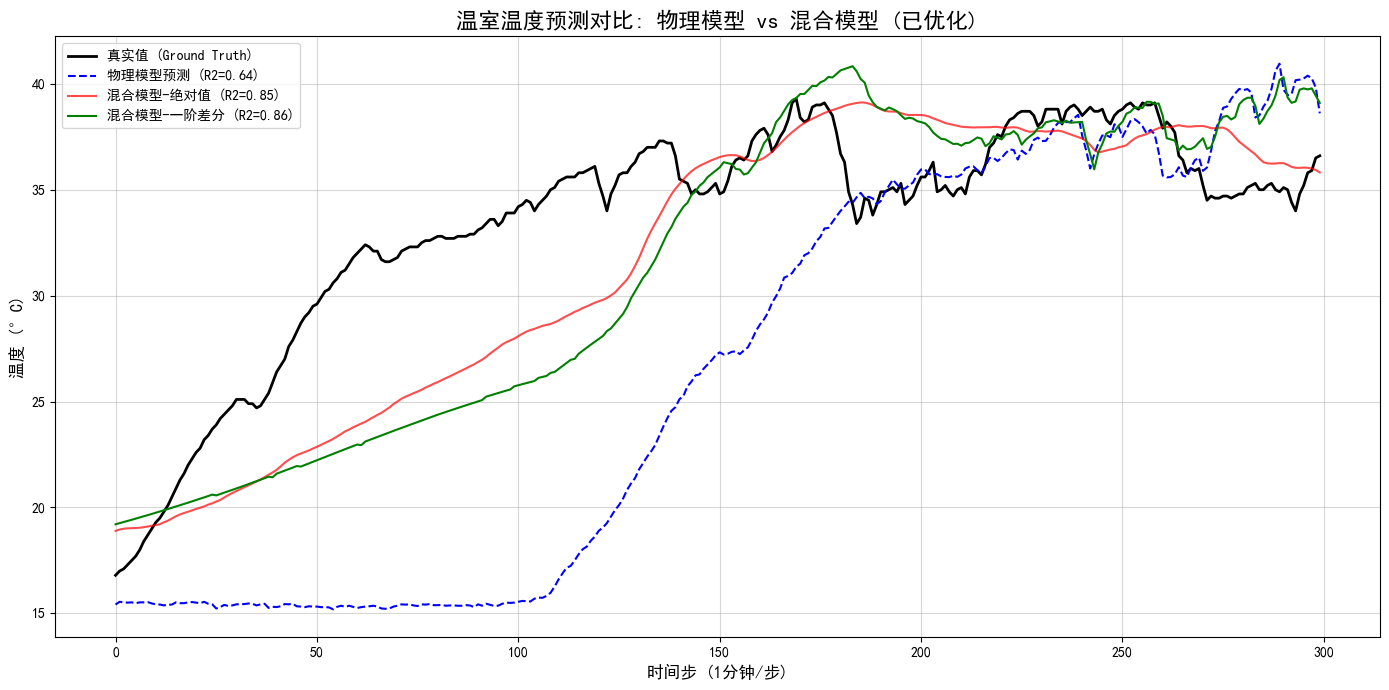


--- 结论分析 ---
1. 物理模型基于简化的线性假设，其 R2 分数为 0.6389。
2. 混合模型(绝对值方法) R2: 0.8457, MAE: 2.7178
3. 混合模型(一阶差分方法) R2: 0.8649, MAE: 2.4938


In [2]:
import pandas as pd
import sys
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import os

# === 辅助函数与类定义 (PyTorch) ===
# 创建时间序列数据
def create_sequences(data, seq_length, forecast_horizon, future_indices, target_idx):
    xs_past, xs_future, ys, y_bases = [], [], [], []
    # 确保不越界：数据总长度 - (输入序列长度 + 预测距离)
    for i in range(len(data) - seq_length - forecast_horizon + 1):
        # 输入：从 i 开始，取 seq_length 个点
        x_p = data[i:(i + seq_length)]
        # 未来控制序列：从 seq_length 结束开始，取 forecast_horizon 个点
        x_f = data[i + seq_length : i + seq_length + forecast_horizon, future_indices]
        # 任务二：输出整个预测序列 [t+1, ..., t+horizon]
        y = data[i + seq_length : i + seq_length + forecast_horizon, target_idx]
        # 基准值：输入序列的最后一个目标值，用于计算差分
        y_base = data[i + seq_length - 1, target_idx]
        xs_past.append(x_p)
        xs_future.append(x_f)
        ys.append(y)
        y_bases.append(y_base)
    return np.array(xs_past), np.array(xs_future), np.array(ys), np.array(y_bases)

# 2. 对比混合模型 (Complex Past + Simple GRU Future)
class SimpleFutureModel(nn.Module):
    def __init__(self, input_dim, future_dim, forecast_horizon, hidden_dim=32):
        super(SimpleFutureModel, self).__init__()
        # 历史数据处理分支 (CNN + BiGRU + Attention)
        self.past_conv1 = nn.Conv1d(in_channels=input_dim, out_channels=64, kernel_size=3, padding=1)
        self.past_bigru = nn.GRU(input_size=64, hidden_size=hidden_dim, num_layers=2, batch_first=True, bidirectional=True)
        self.past_attention = nn.Linear(hidden_dim * 2, 1)
       
        # 未来控制序列处理分支 (仅使用单向 GRU)
        self.future_gru = nn.GRU(input_size=future_dim, hidden_size=hidden_dim, num_layers=1, batch_first=True)
       
        # 融合层：历史特征 (hidden_dim * 2) + 未来特征 (hidden_dim)
        self.fc = nn.Linear(hidden_dim * 2 + hidden_dim, forecast_horizon)
    
    def forward(self, x_past, x_future):
        # 处理历史序列 (Complex)
        x_p = x_past.permute(0, 2, 1)
        x_p = torch.relu(self.past_conv1(x_p))
        x_p = x_p.permute(0, 2, 1)
        gru_out_p, _ = self.past_bigru(x_p)
        weights_p = torch.softmax(self.past_attention(gru_out_p), dim=1)
        attended_p = torch.sum(weights_p * gru_out_p, dim=1)
       
        # 处理未来控制序列 (Simple GRU)
        _, h_n = self.future_gru(x_future)
        future_features = h_n[-1]  # 取最后一个时间步
       
        # 特征融合
        combined = torch.cat([attended_p, future_features], dim=1)
        output = self.fc(combined)
        return output

# 评估指标计算
def calculate_metrics(y_true, y_pred, name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"[{name}] MAE: {mae:.4f}, RMSE: {rmse:.4f}, R2: {r2:.4f}")
    return mae, rmse, r2

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# --- 步骤 0: 初始设置 ---
filename = 'Strawberry Greenhouse Environmental Control Dataset(version2).csv'
print(f"--- 开始处理文件: '{filename}' ---")

try:
    # --- 步骤 1-3: 数据加载, 清洗, 重采样, 填充 ---
    print("--> 正在加载和预处理数据...")
    df = pd.read_csv(filename, encoding='latin1', sep=';', decimal=',', parse_dates=['Timestamp'], dayfirst=True, index_col='Timestamp')
    # 修复：在转换为数值之前处理开关量列，防止被 to_numeric 转为 NaN 而丢弃
    cols_to_binary = [' "Heater"', ' "Ventilation"', ' "Lighting"', ' "Pump 1"', ' "Valve 1"']
    for col in cols_to_binary:
        if col in df.columns:
            df[col] = df[col].apply(lambda x: 1 if str(x).lower() in ['on', 'yes', '1'] else 0)
    for col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    df.dropna(axis=1, how='all', inplace=True)
    df_resampled = df.resample('1min').mean().ffill().bfill()
    print(f"--> 数据预处理完成。维度: {df_resampled.shape}")
except Exception as e:
    print(f"处理数据时发生错误: {e}")
    sys.exit(1)

# --- 步骤 4: 物理基准模型构建 ---
print(f"\n--- 正在构建物理基准模型 ---")
# !!! 关键修改：将预测步长定义提前，确保物理模型和混合模型一致 !!!
# 1小时 = 60分钟 = 60 个 1分钟点
forecast_horizon = 120
print(f"--> 物理模型预测步长设定为: {forecast_horizon} 分钟")

physics_features = [' "Temperature, °C"', ' "Humidity, %"', ' "CO?, ppm"', ' "Heater"', ' "Ventilation"', ' "Lighting"', 'Outdoor_Temp', 'Outdoor_Hum', 'Outdoor_Wind', 'Outdoor_Solar']
target_col = ' "Temperature, °C"'
available_physics_features = [col for col in physics_features if col in df_resampled.columns]

# 准备数据
data = df_resampled[available_physics_features].dropna()
if len(data) < forecast_horizon + 1: sys.exit("错误: 物理模型数据不足。")

# !!! 修正数据切片逻辑 !!!
# 输入 X: 从 0 到 总长度 - horizon
# 输出 y: 从 horizon 到 结尾
# 这样建立了 X_t -> y_{t+60} 的关系
X_physics = data.iloc[:-forecast_horizon].copy()
y_physics = data[target_col].iloc[forecast_horizon:].values

control_features = [col for col in [' "Heater"', ' "Ventilation"', ' "Lighting"'] if col in available_physics_features and col != target_col]

# 使用所有可用的物理特征（包含室外天气等）
feature_columns = available_physics_features

# --- 物理模型增强：加入未来控制量的均值 ---
# 计算未来 forecast_horizon 时间段内的控制变量均值
X_physics_augmented = X_physics.copy()
for col in control_features:
    # rolling(window).mean() 计算的是过去窗口的均值，shift(-window) 将其对齐到未来
    # 这样 X_physics_augmented[t] 就包含了 t 到 t+horizon 期间 heater 的平均开启率
    X_physics_augmented[f'Future_Mean_{col}'] = data[col].rolling(window=forecast_horizon).mean().shift(-forecast_horizon).iloc[:-forecast_horizon]

feature_columns = feature_columns + [f'Future_Mean_{col}' for col in control_features]
X_physics_features = X_physics_augmented[feature_columns].fillna(0).values

train_size = int(len(X_physics) * 0.8)
if train_size == 0: sys.exit("错误: 训练数据不足。")

X_train_phy, X_test_phy = X_physics_features[:train_size], X_physics_features[train_size:]
y_train_phy, y_test_phy = y_physics[:train_size], y_physics[train_size:]

physics_model = LinearRegression()
physics_model.fit(X_train_phy, y_train_phy)
y_pred_phy = physics_model.predict(X_test_phy)
print("---> 物理基准模型训练完成。")

# --- 步骤 5: 混合深度学习模型构建 (PyTorch) ---
print("\n--- 正在构建与训练混合深度学习模型 (PyTorch) ---")

df_hybrid = df_resampled.copy()

# 引入时间位置特征 (Time-of-Day Encoding)
hour_float = df_hybrid.index.hour + df_hybrid.index.minute / 60.0
df_hybrid['Hour_Sin'] = np.sin(2 * np.pi * hour_float / 24.0)
df_hybrid['Hour_Cos'] = np.cos(2 * np.pi * hour_float / 24.0)

input_features = [' "Temperature, °C"', ' "Humidity, %"', ' "CO?, ppm"', ' "Heater"', ' "Ventilation"', ' "Lighting"', 'Outdoor_Temp', 'Outdoor_Hum', 'Outdoor_Wind', 'Outdoor_Solar', 'Hour_Sin', 'Hour_Cos']
available_input_features = [f for f in input_features if f in df_hybrid.columns]
target_index = available_input_features.index(target_col)

# 获取控制变量的索引
control_indices = [available_input_features.index(col) for col in control_features]

# 将时间特征也视为“已知未来”的控制变量
time_indices = [available_input_features.index(col) for col in ['Hour_Sin', 'Hour_Cos'] if col in available_input_features]

# 1. 定义天气列
weather_cols = ['Outdoor_Temp', 'Outdoor_Hum', 'Outdoor_Wind', 'Outdoor_Solar']
weather_indices = [available_input_features.index(col) for col in weather_cols if col in available_input_features]

# 2. 加入未来索引
# 逻辑：未来预测 = f(未来控制 + 未来时间 + 未来天气预报)
future_indices = control_indices + time_indices + weather_indices
print(f"--> 未来特征索引检查: {future_indices} (确认包含了天气列的索引)")

scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(df_hybrid[available_input_features])

# --- 数据集划分 (训练、验证、测试) ---
# --- 参数设置区域 ---
# 假设数据间隔是 5分钟 (df_resampled 是 5min 一行)
# 1. 设置输入窗口：比如看过去 2小时的数据来预测
# 2小时 = 120分钟 = 120 个 1分钟点
sequence_length = 120
print(f"--- 正在构建数据集: 输入过去 {sequence_length} 分钟，预测未来 {forecast_horizon} 分钟 ---")

# 原始训练数据
train_data_full = scaled_features[:train_size]
# 原始测试数据
test_data = scaled_features[train_size:]

# 将原始训练数据进一步划分为训练集和验证集 (80/20)
val_split_index = int(len(train_data_full) * 0.8)
train_data = train_data_full[:val_split_index]
val_data = train_data_full[val_split_index:]

# 创建序列
X_train_past, X_train_future, y_train, y_train_bases = create_sequences(train_data, sequence_length, forecast_horizon, future_indices, target_index)
X_val_past, X_val_future, y_val, y_val_bases = create_sequences(val_data, sequence_length, forecast_horizon, future_indices, target_index)
X_test_past, X_test_future, y_test_scaled, y_test_bases = create_sequences(test_data, sequence_length, forecast_horizon, future_indices, target_index)

if len(X_train_past) == 0 or len(X_val_past) == 0 or len(X_test_past) == 0:
    sys.exit("错误: 创建序列后数据不足以划分训练/验证/测试集。")

# 转换为PyTorch张量
X_train_past_tensor = torch.FloatTensor(X_train_past)
X_train_future_tensor = torch.FloatTensor(X_train_future)
y_train_tensor = torch.FloatTensor(y_train)
y_train_bases_tensor = torch.FloatTensor(y_train_bases).unsqueeze(1)

X_val_past_tensor = torch.FloatTensor(X_val_past)
X_val_future_tensor = torch.FloatTensor(X_val_future)
y_val_tensor = torch.FloatTensor(y_val)
y_val_bases_tensor = torch.FloatTensor(y_val_bases).unsqueeze(1)

X_test_past_tensor = torch.FloatTensor(X_test_past)
X_test_future_tensor = torch.FloatTensor(X_test_future)
y_test_bases_tensor = torch.FloatTensor(y_test_bases).unsqueeze(1)

# 创建DataLoader
train_dataset = TensorDataset(X_train_past_tensor, X_train_future_tensor, y_train_tensor, y_train_bases_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

val_dataset = TensorDataset(X_val_past_tensor, X_val_future_tensor, y_val_tensor, y_val_bases_tensor)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# --- 模型训练与早停机制 ---
# 新增: 设备选择
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"--> 使用设备: {device}")

# --- 训练函数 ---
def train_and_predict(model, model_name, train_loader, val_loader, X_test_p, X_test_f, y_test_bases, scaler, target_idx, feat_cols, available_physics_features, predict_diff=False, lambda_trend=0.5):
    print(f"--> 正在训练 {model_name}...")
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
    num_epochs, patience = 200, 10
    best_val_loss, epochs_no_improve = float('inf'), 0
    model_path = f"best_{model_name}.pth"
    
    for epoch in range(num_epochs):
        model.train()
        for b_Xp, b_Xf, b_y, b_base in train_loader:
            b_Xp, b_Xf, b_y, b_base = b_Xp.to(device), b_Xf.to(device), b_y.to(device), b_base.to(device)
            optimizer.zero_grad()
           
            pred = model(b_Xp, b_Xf)
            # 如果是差分模式，目标是 (未来值 - 当前基准值)
            target = (b_y - b_base) if predict_diff else b_y
           
            # 基础 MSE 损失
            loss_mse = criterion(pred, target)
           
            # 任务三：趋势惩罚 (Gradient Penalty)
            # 计算预测序列和目标序列的变化率（一阶差分）
            pred_diff = pred[:, 1:] - pred[:, :-1]
            target_diff = target[:, 1:] - target[:, :-1]
            loss_trend = criterion(pred_diff, target_diff)
           
            loss = loss_mse + lambda_trend * loss_trend
            loss.backward()
            optimizer.step()
       
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for b_Xp, b_Xf, b_y, b_base in val_loader:
                b_Xp, b_Xf, b_y, b_base = b_Xp.to(device), b_Xf.to(device), b_y.to(device), b_base.to(device)
                target = (b_y - b_base) if predict_diff else b_y
                val_loss += criterion(model(b_Xp, b_Xf), target).item()  # 验证集仅观察 MSE
       
        avg_val_loss = val_loss / len(val_loader)
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), model_path)
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
        if epochs_no_improve >= patience: break
    
    model.load_state_dict(torch.load(model_path))
    model.eval()
    with torch.no_grad():
        pred_tensor = model(X_test_p.to(device), X_test_f.to(device))
        # 仅取序列的最后一个点进行最终评估（对应 t+horizon）
        pred_final = pred_tensor[:, -1].unsqueeze(1)
       
        # 如果是差分模式，还原绝对值：预测的变化量 + 测试集基准值
        if predict_diff:
            pred_final = pred_final + torch.FloatTensor(y_test_bases).to(device).unsqueeze(1)
   
    pred_np = pred_final.cpu().numpy()
    dummy = np.zeros((len(pred_np), len(feat_cols)))
    dummy[:, target_idx] = pred_np.ravel()
    os.remove(model_path)
    return scaler.inverse_transform(dummy)[:, target_idx]

input_dim, future_dim = X_train_past_tensor.shape[2], len(future_indices)

# 实例化两个模型
model_abs = SimpleFutureModel(input_dim, future_dim, forecast_horizon).to(device)
model_diff = SimpleFutureModel(input_dim, future_dim, forecast_horizon).to(device)

# 1. 训练原方法（预测绝对值）
y_pred_abs = train_and_predict(model_abs, "混合模型(绝对值)", train_loader, val_loader,
                               X_test_past_tensor, X_test_future_tensor, y_test_bases, scaler, target_index, available_input_features, available_physics_features, predict_diff=False)

# 2. 训练新方法（预测一阶差分）
y_pred_diff = train_and_predict(model_diff, "混合模型(一阶差分)", train_loader, val_loader,
                                X_test_past_tensor, X_test_future_tensor, y_test_bases, scaler, target_index, available_input_features, available_physics_features, predict_diff=True)

# 获取真实值
dummy_true = np.zeros((len(y_test_scaled), len(available_input_features)))
dummy_true[:, target_index] = y_test_scaled[:, -1].ravel()  # 取序列最后一个点
y_test_hybrid = scaler.inverse_transform(dummy_true)[:, target_index]

# --- 步骤 6: 评估与可视化 ---
print("\n--- 性能对比 ---")

start_offset = sequence_length
end_offset = start_offset + len(y_test_hybrid)
y_test_phy_aligned = y_test_phy[start_offset:end_offset]
y_pred_phy_aligned = y_pred_phy[start_offset:end_offset]

min_len = min(len(y_test_hybrid), len(y_test_phy_aligned))

m1 = calculate_metrics(y_test_phy_aligned[:min_len], y_pred_phy_aligned[:min_len], "基准: 物理微分方程模型")
m2 = calculate_metrics(y_test_hybrid[:min_len], y_pred_abs[:min_len], "本文: 混合模型(绝对值)")
m3 = calculate_metrics(y_test_hybrid[:min_len], y_pred_diff[:min_len], "本文: 混合模型(一阶差分)")

plt.figure(figsize=(14, 7))
plot_len = min(300, min_len)
plt.plot(y_test_phy_aligned[:plot_len], label='真实值 (Ground Truth)', color='black', linewidth=2)
plt.plot(y_pred_phy_aligned[:plot_len], label=f'物理模型预测 (R2={m1[2]:.2f})', color='blue', linestyle='--')
plt.plot(y_pred_abs[:plot_len], label=f'混合模型-绝对值 (R2={m2[2]:.2f})', color='red', linewidth=1.5, alpha=0.7)
plt.plot(y_pred_diff[:plot_len], label=f'混合模型-一阶差分 (R2={m3[2]:.2f})', color='green', linewidth=1.5)
plt.title(f"温室温度预测对比: 物理模型 vs 混合模型 (已优化)", fontsize=16)
plt.xlabel("时间步 (1分钟/步)", fontsize=12)
plt.ylabel("温度 (°C)", fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.5)
plt.tight_layout()
plt.show()

# --- 步骤 7: 输出结论文本 ---
print("\n--- 结论分析 ---")
print(f"1. 物理模型基于简化的线性假设，其 R2 分数为 {m1[2]:.4f}。")
print(f"2. 混合模型(绝对值方法) R2: {m2[2]:.4f}, MAE: {m2[0]:.4f}")
print(f"3. 混合模型(一阶差分方法) R2: {m3[2]:.4f}, MAE: {m3[0]:.4f}")